In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load data
ckpt_root = Path('./checkpoints/kodak/GaussianImage_Cholesky_50000_9000')
data_root = Path('../Dataset/kodak')

In [3]:
item = 'kodim01'
img = data_root / (item + '.png')
ckpt_path = ckpt_root / item / 'gaussian_model.pth.tar'
print(img)
print(ckpt_path)


..\Dataset\kodak\kodim01.png
checkpoints\kodak\GaussianImage_Cholesky_50000_9000\kodim01\gaussian_model.pth.tar


In [6]:
import torch
from gaussianimage_cholesky import GaussianImage_Cholesky
import torchvision.transforms as transforms
from PIL import Image

def image_path_to_tensor(image_path: Path):
    img = Image.open(image_path)
    transform = transforms.ToTensor()
    img_tensor = transform(img).unsqueeze(0) #[1, C, H, W]
    return img_tensor

BLOCK_H, BLOCK_W = 16, 16
device = torch.device("cuda:0")
gt_image = image_path_to_tensor(img).to(device)
H, W = gt_image.shape[2], gt_image.shape[3]

model = GaussianImage_Cholesky(
          loss_type="L2", opt_type="adan", 
          num_points=9000, 
          H=H, W=W, BLOCK_H=BLOCK_H, BLOCK_W=BLOCK_W, 
          device=device, lr=1e-3, quantize=False).to(device)

ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt)


<All keys matched successfully>

In [7]:
from gsplat.project_gaussians_2d import project_gaussians_2d
from gsplat.rasterize_sum import rasterize_gaussians_sum
model.xys, depths, model.radii, conics, num_tiles_hit = project_gaussians_2d(model.get_xyz, model.get_cholesky_elements, model.H, model.W, model.tile_bounds)

In [10]:
print(model.xys.shape, model.xys[:5])
print(model.radii.shape, model.radii[:5])
print(conics.shape, conics[:5])
print(num_tiles_hit.shape, num_tiles_hit[:5])

out_img = rasterize_gaussians_sum(model.xys, depths, model.radii, conics, num_tiles_hit,
                model.get_features, model._opacity, H, W, BLOCK_H, BLOCK_W, background=model.background, return_alpha=False)
out_img = torch.clamp(out_img, 0, 1) #[H, W, 3]
out_img = out_img.view(-1, H, W, 3).permute(0, 3, 1, 2).contiguous()
        

torch.Size([9000, 2]) tensor([[598.9110, 147.8466],
        [310.4904, 390.8795],
        [ 22.2274, 411.3068],
        [307.5680, 373.0743],
        [445.4391, 226.3039]], device='cuda:0', grad_fn=<SliceBackward0>)
torch.Size([9000]) tensor([13, 37,  5, 15,  7], device='cuda:0', dtype=torch.int32)
torch.Size([9000, 3]) tensor([[ 0.1001, -0.2118,  1.2223],
        [ 4.9260, -0.0124,  0.0069],
        [ 0.4771, -0.0999,  0.5617],
        [ 5.3842, -0.0234,  0.0446],
        [ 0.2121,  0.0560,  0.3903]], device='cuda:0',
       grad_fn=<SliceBackward0>)
torch.Size([9000]) tensor([ 9, 25,  2,  9,  4], device='cuda:0', dtype=torch.int32)


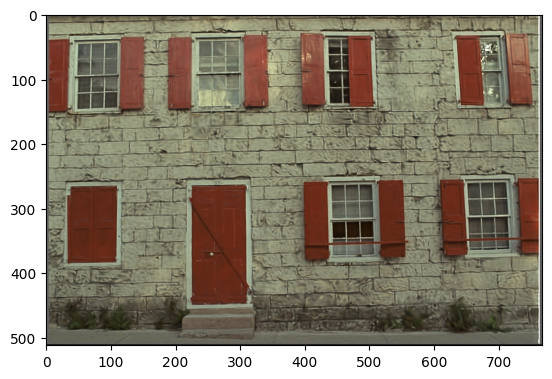

In [11]:
out_img_ = out_img.permute(0, 2,3,1).cpu().detach().numpy()[0]

plt.imshow(out_img_)